Example code for Task 5: Model Iterations.
This script demonstrates how to:
1. Load a CSV file containing NLP features (from Task 4).
2. Parse columns such as TF-IDF, sentiment scores, custom embeddings, etc.
3. Encode the target emotion labels.
4. Train and evaluate:
   - Logistic Regression
   - Naive Bayes
   - LSTM (Keras/TensorFlow)
   - RNN (Keras/TensorFlow)
   - Two Transformer models (via Hugging Face)

You should adapt paths, filenames, column names, and any language-specific libraries
to match your actual data and environment.

Ensure you record each model's details (features used, hyperparameters, metrics)
in your model iteration file (required by Task 5).

---
## INSTALL REQUIRED LIBRARIES

In [1]:
# !pip install scikit-learn numpy pandas tensorflow torch transformers sentencepiece gensim datasets

import numpy as np
import pandas as pd

# Sklearn for classic models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.callbacks import EarlyStopping
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from gensim.models import Word2Vec
import nltk
from tqdm import tqdm

# TensorFlow/Keras for LSTM, RNN
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Input, Add, Bidirectional

# Hugging Face Transformers
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from transformers import DataCollatorWithPadding
import transformers
import keras

NUM_TEST_SAMPLES = 1044
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-04-07 08:25:55.754842: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 08:25:55.791169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 08:25:55.791197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 08:25:55.792860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 08:25:55.800136: I tensorflow/core/platform/cpu_feature_guar

## STEP 1: LOAD THE CSV FILE CONTAINING NLP FEATURES

In [2]:
df = pd.read_parquet('group_combined_no_features.parquet')
print(f"DataFrame shape after dropping NaN values: {df.shape}")
print(f"DataFrame columns: {df.columns.tolist()}")
df.dropna(inplace=True)
df.head()

DataFrame shape after dropping NaN values: (87267, 3)
DataFrame columns: ['ru_text', 'text', 'general_emotion']


,ru_text,text,general_emotion
0,"Après l'Asie, l'Afrique, les Etats-Unis et l'A...",after asia africa the united states and latin ...,neutral
1,les Mercedes s'envolent à plus de 16 000 kilom...,the mercedes fly over kilometers from their home,neutral
2,et posent leur valise en Australie.,and put their suitcase in australia,neutral
3,"Ensemble, ils relèvent le défi de s'imposer en...",together they take up the challenge of winning...,happiness
4,et de découvrir ce pays aussi magnifique,and to discover this magnificent country,surprise


## STEP 2: PARSE FEATURES (TF-IDF, embeddings, etc.)

In [3]:
# df['TF_IDF'] = df['TF_IDF'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
# df['pretrained_embeddings'] = df['pretrained_embeddings'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
# df['custom_embeddings'] = df['custom_embeddings'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
# df['pos_tags'] = df['pos_tags'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))
# df['named_entities'] = df['named_entities'].apply(lambda x: np.array(list(map(float, str(x).split(',')))))

In [4]:
df.head()

,ru_text,text,general_emotion
0,"Après l'Asie, l'Afrique, les Etats-Unis et l'A...",after asia africa the united states and latin ...,neutral
1,les Mercedes s'envolent à plus de 16 000 kilom...,the mercedes fly over kilometers from their home,neutral
2,et posent leur valise en Australie.,and put their suitcase in australia,neutral
3,"Ensemble, ils relèvent le défi de s'imposer en...",together they take up the challenge of winning...,happiness
4,et de découvrir ce pays aussi magnifique,and to discover this magnificent country,surprise


## STEP 3: ENCODE THE TARGET EMOTION LABEL

In [5]:
label_encoder = LabelEncoder()
df["emotion_encoded"] = label_encoder.fit_transform(df["general_emotion"])
classes_ = label_encoder.classes_
num_classes = len(classes_)
print("Emotion classes:", classes_)

Emotion classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']


In [6]:
# Save the label encoder as a pickle file
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [6]:
df['general_emotion'].value_counts()

general_emotion
neutral      29703
happiness    27417
surprise     13431
anger         9290
sadness       4761
fear          1653
disgust       1012
Name: count, dtype: int64

In [ ]:
# train_df = df.iloc[:-NUM_TEST_SAMPLES]
# test_df = df.iloc[-NUM_TEST_SAMPLES:]

# # Balance the dataset by sampling of the same size as the smallest class
# min_class_size = train_df['emotion_encoded'].value_counts().min()
# df_balanced = train_df.groupby('emotion_encoded').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)
# print(f"Balanced DataFrame shape: {df_balanced.shape}")
# print(f"Balanced DataFrame columns: {df_balanced.columns.tolist()}")

# df_balanced['emotion_encoded'].value_counts().plot(kind='bar', title='Balanced Emotion Classes')

In [ ]:
# test_df['emotion_encoded'].value_counts().plot(kind='bar')

## STEP 4: BUILD A FEATURE MATRIX X (FOR CLASSIC MODELS)

In [ ]:
import numpy as np
from scipy.sparse import hstack

# Convert each feature column into a NumPy array
X_tfidf = np.vstack(df["TF_IDF"])
X_pretrained = np.vstack(df["pretrained_embeddings"])
X_custom = np.vstack(df["custom_embeddings"])
X_pos = np.vstack(df["pos_tags"])
X_entities = np.vstack(df["named_entities"])

# Combine all features into a single matrix
X = np.hstack([X_pretrained, X_custom, X_pos, X_entities])  # Use hstack for feature fusion
y = df["emotion_encoded"].values  # Convert to NumPy array

print(X.shape, y.shape)  # Check the final shape


(55307, 664) (55307,)


general_emotion
happiness    20750
neutral      17294
anger         6244
surprise      5894
sadness       3470
disgust        831
fear           824
Name: count, dtype: int64


7

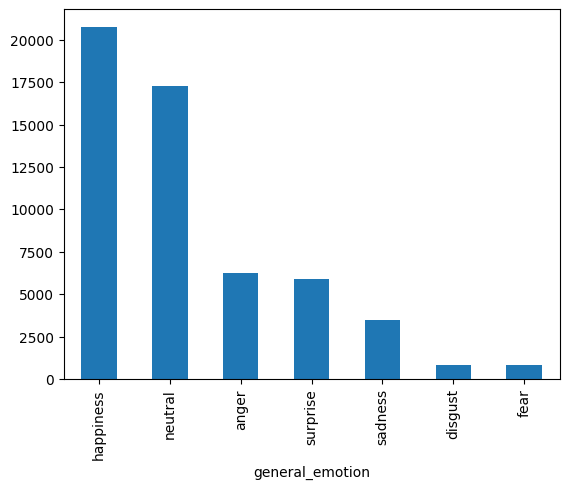

In [ ]:
# Bar plot for frequency of emeotions
df["general_emotion"].value_counts().plot(kind="bar")
print(df["general_emotion"].value_counts())

# Difference between 2 smallest classes
df["general_emotion"].value_counts().iloc[-2] - df["general_emotion"].value_counts().iloc[-1]

## STEP 5: SPLIT DATA FOR CLASSIC MODELS (LOGREG, NB)

In [ ]:
# Split the data
X_train, X_test = X[:-NUM_TEST_SAMPLES], X[-NUM_TEST_SAMPLES:]
y_train, y_test = y[:-NUM_TEST_SAMPLES], y[-NUM_TEST_SAMPLES:]

# Check the shapes to ensure the split is correct
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (54258, 664)
X_test shape: (1049, 664)
y_train shape: (54258,)
y_test shape: (1049,)


## STEP 6: LOGISTIC REGRESSION

In [ ]:
print("\n=== Logistic Regression ===")
lr_clf = LogisticRegression(max_iter=300)
# If X is not a standard 2D float array, convert X_train/X_test to lists
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
print("F1 (wighted):", f1_lr)
print(classification_report(y_test, y_pred_lr, target_names=classes_))


=== Logistic Regression ===
F1 (wighted): 0.44619179365005607
              precision    recall  f1-score   support

       anger       0.14      0.03      0.04        39
     disgust       0.00      0.00      0.00        12
        fear       0.00      0.00      0.00         6
   happiness       0.57      0.59      0.58       387
     neutral       0.47      0.71      0.56       399
     sadness       0.00      0.00      0.00        20
    surprise       0.43      0.05      0.10       186

    accuracy                           0.50      1049
   macro avg       0.23      0.20      0.18      1049
weighted avg       0.47      0.50      0.45      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is 

## STEP 7: NAIVE BAYES

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply MaxAbsScaler (preserves sparsity)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MultinomialNB on the transformed data
nb_clf = MultinomialNB()
nb_clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_nb = nb_clf.predict(X_test_scaled)
f1_nb = f1_score(y_test, y_pred_nb,  average="weighted")

print("F1 (weighted):", f1_nb)
print(classification_report(y_test, y_pred_nb, target_names=classes_))

F1 (weighted): 0.38107408449522107
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        39
     disgust       0.00      0.00      0.00        12
        fear       0.00      0.00      0.00         6
   happiness       0.43      0.64      0.52       387
     neutral       0.46      0.55      0.50       399
     sadness       0.00      0.00      0.00        20
    surprise       0.00      0.00      0.00       186

    accuracy                           0.45      1049
   macro avg       0.13      0.17      0.15      1049
weighted avg       0.33      0.45      0.38      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

## Prepare data for RNN and LSTM

In [ ]:
texts = df['text'].values
labels = df['emotion_encoded'].values
print(f"Texts shape: {texts.shape}")    
print(f"Labels shape: {labels.shape}")

Texts shape: (55307,)
Labels shape: (55307,)


In [ ]:
# Tokenization and sequence conversion
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_length = max(64, max(len(seq) for seq in sequences))  # Ensure max_length is at least 64
print("max_length:", max_length)
print("Vocabulary size:", vocab_size)
 
# Padding sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Splitting the data
X_train_pad, X_test_pad = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)

max_length: 64
Vocabulary size: 29464
X_train_pad shape: (54263, 64)
X_test_pad shape: (1044, 64)


In [ ]:
# path = "glove.840B.300d.txt"

# embeddings_index = {}
# f = open(path,'r',encoding='utf-8')
# for line in tqdm(f):
#     values = line.split(' ')
#     word = values[0]
#     coefs = np.asarray([float(val) for val in values[1:]])
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# # create an embedding matrix for the words we have in the dataset
# embedding_matrix = np.zeros((len(word_index) + 1, 300))
# for word, i in tqdm(word_index.items()):
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# # Save the embedding matrix to a file
# np.save('embedding_matrix.npy', embedding_matrix)

# Load the embedding matrix from the file
embedding_matrix = np.load('embedding_matrix.npy')
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (29464, 300)


## STEP 8: RNN MODEL without pre-trained embeddings

In [ ]:
# Split the train into validation and training
X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

# Build RNN Model
rnn = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, 300),
    SimpleRNN(256, activation='tanh', return_sequences=False),
    Dense(num_classes, activation='softmax')
])
 
# Compile and train the model
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='weighted')])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 300)           8839200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 8983591 (34.27 MB)
Trainable params: 8983591 (34.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = rnn.fit(X_train_pad, y_train, epochs=50, batch_size=16, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/50


2025-03-31 19:25:42.109097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcf4e70b170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-31 19:25:42.109145: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-31 19:25:42.120823: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-31 19:25:42.478199: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1743449142.614830     886 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 301/2714 [==>...........................] - ETA: 3:26 - loss: 1.5844 - f1_score: 0.2781

KeyboardInterrupt: 

In [ ]:
# Predict and evaluate
y_pred_rnn = rnn.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
f1_rnn = f1_score(np.argmax(y_test, axis=1), y_pred_rnn, average="weighted")
print("F1 (macro):", f1_rnn)
print(classification_report(np.argmax(y_test, axis=1), y_pred_rnn, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
F1 (macro): 0.3092084153558339
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        39
     disgust       0.00      0.00      0.00        12
        fear       0.00      0.00      0.00         6
   happiness       0.38      0.64      0.47       387
     neutral       0.36      0.35      0.35       399
     sadness       0.00      0.00      0.00        20
    surprise       0.00      0.00      0.00       186

    accuracy                           0.37      1049
   macro avg       0.10      0.14      0.12      1049
weighted avg       0.27      0.37      0.31      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

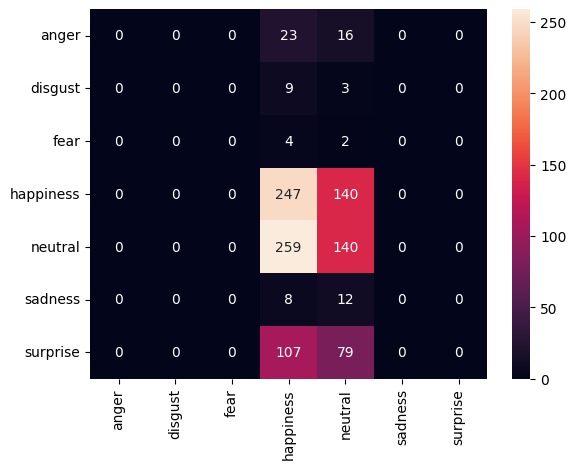

In [ ]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_rnn)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes_, yticklabels=classes_)

### STEP 8: pre-trained embeddings

In [ ]:
# Build RNN Model
rnn2 = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False),
    SimpleRNN(256, activation='tanh', return_sequences=False),
    Dense(num_classes, activation='softmax')
])
 
# Compile and train the model
# Compile and train the model
rnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='weighted')])
rnn2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 64, 300)        │     8,839,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 256)            │       142,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,983,591 (34.27 MB)

 Trainable params: 144,391 (564.03 KB)

 Non-trainable params: 8,839,200 (33.72 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = rnn2.fit(X_train_pad, y_train, epochs=50, batch_size=16, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - f1_score: 0.2766 - loss: 1.5932 - val_f1_score: 0.2056 - val_loss: 1.5569
Epoch 2/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - f1_score: 0.2702 - loss: 1.5550 - val_f1_score: 0.2053 - val_loss: 1.5407
Epoch 3/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - f1_score: 0.2772 - loss: 1.5528 - val_f1_score: 0.3369 - val_loss: 1.5636
Epoch 4/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - f1_score: 0.3112 - loss: 1.5349 - val_f1_score: 0.2147 - val_loss: 1.5367
Epoch 5/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - f1_score: 0.2743 - loss: 1.5486 - val_f1_score: 0.2139 - val_loss: 1.5393
Epoch 6/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - f1_score: 0.2756 - loss: 1.5562 - val_f1_score: 0.2120 - val_loss: 1.5384
Epoch 7/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - f1_score: 0.2772 - loss: 1.5535 - val_f1_score: 0.2048 - val_loss: 1.5378
Epoch 8/50
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - f1_score: 0.2764 - loss:

In [ ]:
# Predict and evaluate
y_pred_rnn = rnn2.predict(X_test_pad)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
f1_rnn = f1_score(np.argmax(y_test, axis=1), y_pred_rnn, average="weighted")
print("F1 (macro):", f1_rnn)
print(classification_report(np.argmax(y_test, axis=1), y_pred_rnn, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1 (macro): 0.26583618491539746
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        39
     disgust       0.00      0.00      0.00        12
        fear       0.00      0.00      0.00         6
   happiness       0.38      0.93      0.54       387
     neutral       0.46      0.11      0.18       399
     sadness       0.00      0.00      0.00        20
    surprise       0.00      0.00      0.00       186

    accuracy                           0.39      1049
   macro avg       0.12      0.15      0.10      1049
weighted avg       0.32      0.39      0.27      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

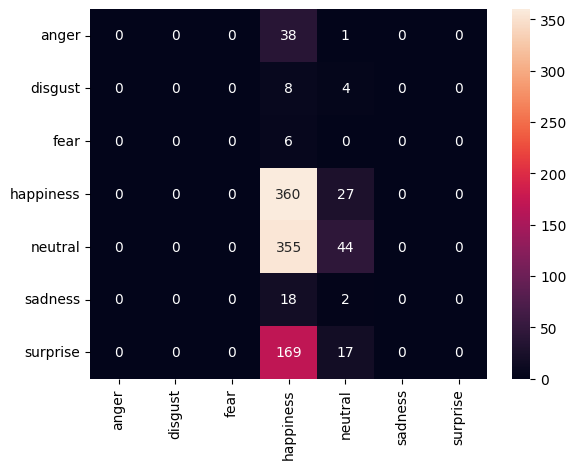

In [ ]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_rnn)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes_, yticklabels=classes_)

## STEP 9: LSTM MODEL (Keras) FOR TEXT

### LSTM 1

In [ ]:
# Load the embedding matrix from the file
embedding_matrix = np.load('embedding_matrix.npy')
print("Embedding matrix shape:", embedding_matrix.shape)

# Split data
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
 
def create_model_lstm_1():
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.SpatialDropout1D(0.2),
        LSTM(512, return_sequences=False),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]
    ,name="lstm_1")
    
    adam = tf.keras.optimizers.AdamW(learning_rate=5e-4)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='weighted')])
    model.summary()
    
    return model

Embedding matrix shape: (29464, 300)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

lstm1 = create_model_lstm_1()

# Train the model on the fold
history = lstm1.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)


Model: "lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 300)           8839200   
                                                                 
 spatial_dropout1d (Spatial  (None, 64, 300)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                            

KeyboardInterrupt: 

In [ ]:
# Predict and evaluate
y_pred_lstm = lstm1.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (macro):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1 (macro): 0.19884835272218399
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        39
     disgust       0.00      0.00      0.00        12
        fear       0.00      0.00      0.00         6
   happiness       0.37      1.00      0.54       387
     neutral       0.00      0.00      0.00       399
     sadness       0.00      0.00      0.00        20
    surprise       0.00      0.00      0.00       186

    accuracy                           0.37      1049
   macro avg       0.05      0.14      0.08      1049
weighted avg       0.14      0.37      0.20      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import StratifiedKFold

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# # Learning rate scheduler function
# def scheduler(epoch, lr):
#     if epoch > 3:
#         return lr * float(tf.math.exp(-0.15))
#     return lr

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# # Number of K folds
# k = 5  # You can change this number based on your needs

# # Initialize KFold cross-validation
# kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# # Lists to store performance metrics for each fold
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# fold_no = 1
# for train_index, val_index in kf.split(X_train):
#     # Split data into train and validation sets
#     X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#     y_train_fold, y_val_fold = np.array(y_train)[train_index], np.array(y_train)[val_index]
    
#     print(f"Training fold {fold_no} of {k}...")
    
#     # Initialize the model (make sure it's re-initialized for each fold)
#     model = create_model_lstm_1()  # Replace with your model creation function
    
#     # Train the model on the fold
#     history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, 
#                         validation_data=(X_val_fold, y_val_fold),
#                         callbacks=[early_stopping, lr_scheduler],
#                         verbose=1, class_weight=class_weights)
    
#     # Find the epoch where early stopping occurred
#     best_epoch = np.argmin(history.history['val_loss'])  # The epoch with the minimum validation loss
#     # Capture the metrics at the best epoch
#     train_losses.append(history.history['loss'][best_epoch])  # Training loss at best epoch
#     val_losses.append(history.history['val_loss'][best_epoch])  # Validation loss at best epoch
#     train_accuracies.append(history.history['f1_score'][best_epoch])  # Training accuracy at best epoch
#     val_accuracies.append(history.history['val_f1_score'][best_epoch])  # Validation accuracy at best epoch
    
#     fold_no += 1

# # Calculate averages for each metric
# avg_train_loss = np.mean(train_losses)
# avg_val_loss = np.mean(val_losses)
# avg_train_accuracy = np.mean(train_accuracies)
# avg_val_accuracy = np.mean(val_accuracies)

# print("\nAverage results across all folds:")
# print(f"Average training loss: {avg_train_loss}")
# print(f"Average validation loss: {avg_val_loss}")
# print(f"Average training f1_score: {avg_train_accuracy}")
# print(f"Average validation f1_score: {avg_val_accuracy}")


<Axes: >

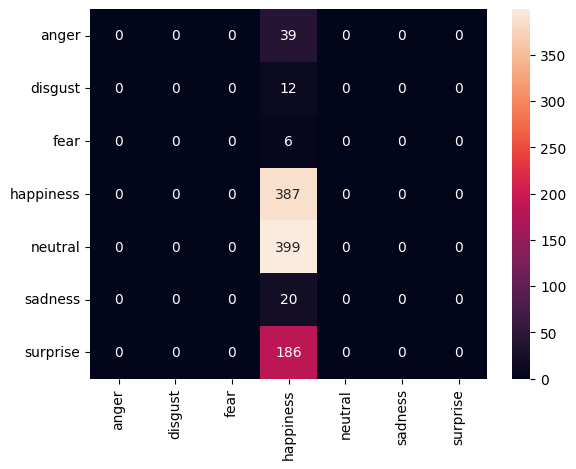

In [ ]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes_, yticklabels=classes_)

In [ ]:
model.save('lstm_300_emb_simple+512layer+dropout.keras')

### LSTM 2


In [ ]:
# Split data (assuming padded_sequences and labels are already defined and shuffled)
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

def create_model_lstm_2():
    # Input Layer
    inputs = Input(shape=(max_length,))
    emb = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
    emb = tf.keras.layers.SpatialDropout1D(0.2)(emb)
    
    # Bidirectional LSTM Layer 1
    x = Bidirectional(LSTM(512, return_sequences=True))(emb)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Residual Block - LSTM 2
    residual1 = x  # Save for residual connection
    x = Bidirectional(LSTM(256, return_sequences=True))(emb)
    x = Dropout(0.2)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    residual1 = Dense(512)(residual1)
    x = Add()([x, residual1])  # Residual connection
    
    # Residual Block - LSTM 3
    residual2 = x  # Save for residual connection
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    residual2 = Dense(256)(residual2)
    x = Add()([x, residual2])  # Residual connection
    
    # LSTM 4 
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.1)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Dense Layer
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model Compilation
    model = tf.keras.models.Model(inputs, outputs, name="lstm_2")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss='categorical_crossentropy',
        metrics=[tf.metrics.F1Score(average='weighted', name='f1_score')]
    )
    
    model.summary()
    
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lstm2 = create_model_lstm_2()

# Train the model on the fold
history = lstm2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Model: "lstm_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 64, 300)   │  8,839,200 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 64, 300)   │          0 │ embedding_12[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64, 1024)  │  3,330,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64, 512)   │  1,140,736 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64, 1024)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 512)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 1024)  │      2,048 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 512)   │      1,024 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64, 256)   │    656,384 │ add[0][0]         │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64, 256)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ dropout_6[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64, 256)   │    131,328 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ add_1[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128)       │        256 │ dropout_7[0][0] 

 Total params: 14,795,047 (56.44 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 8,839,200 (33.72 MB)

Epoch 1/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - f1_score: 0.3285 - loss: 1.4919 - val_f1_score: 0.4359 - val_loss: 1.2096
Epoch 2/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - f1_score: 0.4499 - loss: 1.2732 - val_f1_score: 0.4727 - val_loss: 1.1585
Epoch 3/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - f1_score: 0.4798 - loss: 1.2025 - val_f1_score: 0.4952 - val_loss: 1.0962
Epoch 4/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - f1_score: 0.5006 - loss: 1.1548 - val_f1_score: 0.5119 - val_loss: 1.0745
Epoch 5/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - f1_score: 0.5158 - loss: 1.1248 - val_f1_score: 0.5238 - val_loss: 1.0530
Epoch 6/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - f1_score: 0.5270 - loss: 1.0980 - val_f1_score: 0.5334 - val_loss: 1.0515
Epoch 7/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - f1_score: 0.5359 - loss: 1.0852 - val_f1_score: 0.5415 - val_loss: 1.0434
Epoch 8/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - f1_score: 0.5439 - loss: 1

In [ ]:
# Predict and evaluate
y_pred_lstm = lstm2.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (weighted):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
F1 (weighted): 0.508035334372861
              precision    recall  f1-score   support

       anger       0.52      0.28      0.37        39
     disgust       0.00      0.00      0.00        12
        fear       0.60      0.50      0.55         6
   happiness       0.67      0.60      0.63       387
     neutral       0.49      0.80      0.61       399
     sadness       0.33      0.10      0.15        20
    surprise       0.58      0.08      0.13       186

    accuracy                           0.55      1049
   macro avg       0.46      0.34      0.35      1049
weighted avg       0.57      0.55      0.51      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

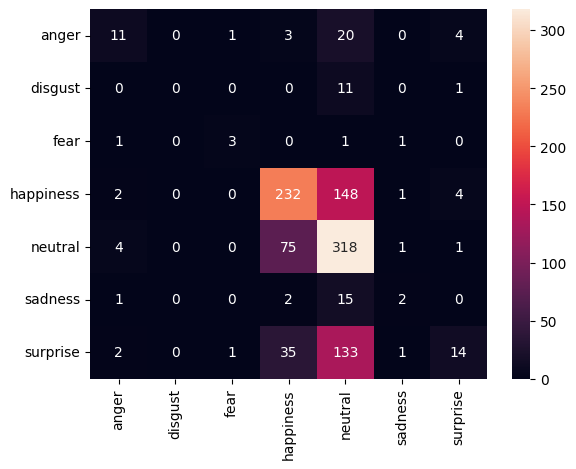

In [ ]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

In [ ]:
model.save('lstm_100_emb_bidir+256+128+64layer+dropout.keras')

### LSTM 3

In [ ]:
from tensorflow.keras.layers import LayerNormalization

# Split data (assuming padded_sequences and labels are already defined and shuffled)
X_train, X_test = padded_sequences[:-NUM_TEST_SAMPLES], padded_sequences[-NUM_TEST_SAMPLES:]
y_train, y_test = labels[:-NUM_TEST_SAMPLES], labels[-NUM_TEST_SAMPLES:]

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# To categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

def create_unet_lstm():
    # Input Layer
    inputs = Input(shape=(max_length,))
    emb = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(inputs)
    emb = tf.keras.layers.SpatialDropout1D(0.2)(emb)

    # Encoder (Downsampling with LSTM)
    enc1 = Bidirectional(LSTM(512, return_sequences=True))(emb)
    enc1 = Dropout(0.2)(enc1)
    enc1 = LayerNormalization()(enc1)

    enc2 = Bidirectional(LSTM(256, return_sequences=True))(enc1)
    enc2 = Dropout(0.2)(enc2)
    enc2 = LayerNormalization()(enc2)

    enc3 = Bidirectional(LSTM(128, return_sequences=True))(enc2)
    enc3 = Dropout(0.2)(enc3)
    enc3 = LayerNormalization()(enc3)

    # Bottleneck
    bottleneck = Bidirectional(LSTM(64, return_sequences=True))(enc3)
    bottleneck = Dropout(0.2)(bottleneck)
    bottleneck = LayerNormalization()(bottleneck)

    # Decoder (Upsampling with LSTM + Skip Connections)
    dec3 = Bidirectional(LSTM(128, return_sequences=True))(bottleneck)
    dec3 = Dropout(0.2)(dec3)
    dec3 = LayerNormalization()(dec3)
    dec3 = Add()([dec3, enc3])  # Skip connection

    dec2 = Bidirectional(LSTM(256, return_sequences=True))(dec3)
    dec2 = Dropout(0.2)(dec2)
    dec2 = LayerNormalization()(dec2)
    dec2 = Add()([dec2, enc2])  # Skip connection

    dec1 = Bidirectional(LSTM(512, return_sequences=True))(dec2)
    dec1 = Dropout(0.2)(dec1)
    dec1 = LayerNormalization()(dec1)
    dec1 = Add()([dec1, enc1])  # Skip connection

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(dec1[:, -1, :])  # Get last time step's output

    # Model Compilation
    model = tf.keras.models.Model(inputs, outputs, name="unet_lstm")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss='categorical_crossentropy',
        metrics=[tf.metrics.F1Score(average='weighted', name='f1_score')]
    )

    model.summary()
    
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

lstm2 = create_model_lstm_2()

# Train the model on the fold
history = lstm2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1)

Model: "lstm_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 64, 300)   │  8,839,200 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, 64, 300)   │          0 │ embedding_13[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 64, 1024)  │  3,330,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64, 512)   │  1,140,736 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 1024)  │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 512)   │          0 │ bidirectional_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 1024)  │      2,048 │ dropout_9[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 512)   │      1,024 │ dropout_10[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64, 512)   │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 512)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 64, 256)   │    656,384 │ add_2[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 256)   │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ dropout_11[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64, 256)   │    131,328 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 128)       │    164,352 │ add_3[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ bidirectional_7[

 Total params: 14,795,047 (56.44 MB)

 Trainable params: 5,955,847 (22.72 MB)

 Non-trainable params: 8,839,200 (33.72 MB)

Epoch 1/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - f1_score: 0.3321 - loss: 1.5126 - val_f1_score: 0.4215 - val_loss: 1.2445
Epoch 2/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - f1_score: 0.4326 - loss: 1.2859 - val_f1_score: 0.4582 - val_loss: 1.1509
Epoch 3/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - f1_score: 0.4669 - loss: 1.2252 - val_f1_score: 0.4815 - val_loss: 1.1277
Epoch 4/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - f1_score: 0.4870 - loss: 1.1828 - val_f1_score: 0.4981 - val_loss: 1.0886
Epoch 5/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - f1_score: 0.5027 - loss: 1.1426 - val_f1_score: 0.5129 - val_loss: 1.0817
Epoch 6/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - f1_score: 0.5167 - loss: 1.1135 - val_f1_score: 0.5246 - val_loss: 1.0615
Epoch 7/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - f1_score: 0.5280 - loss: 1.0943 - val_f1_score: 0.5346 - val_loss: 1.0393
Epoch 8/100
679/679 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - f1_score: 0.5374 - loss: 1

In [ ]:
# Predict and evaluate
y_pred_lstm = lstm2.predict(X_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)
f1_lstm = f1_score(np.argmax(y_test, axis=1), y_pred_lstm, average="weighted")
print("F1 (weighted):", f1_lstm)
print(classification_report(np.argmax(y_test, axis=1), y_pred_lstm, target_names=classes_))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
F1 (weighted): 0.5152806576045319
              precision    recall  f1-score   support

       anger       0.59      0.26      0.36        39
     disgust       0.00      0.00      0.00        12
        fear       0.50      0.50      0.50         6
   happiness       0.68      0.57      0.62       387
     neutral       0.49      0.82      0.62       399
     sadness       0.25      0.10      0.14        20
    surprise       0.62      0.11      0.19       186

    accuracy                           0.55      1049
   macro avg       0.45      0.34      0.35      1049
weighted avg       0.58      0.55      0.52      1049



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

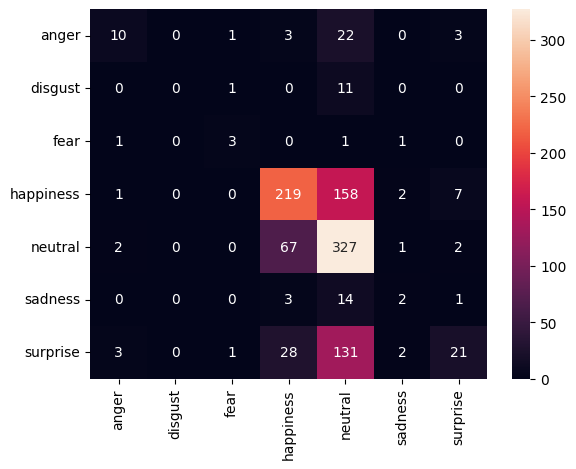

In [ ]:
# Create a normalized confusion matrix for the LSTM model prediction on X_test
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_lstm)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

## STEP 10: TRANSFORMER MODEL #1 (Example: BERT)

In [ ]:
import wandb

wandb.init(project="Transformers", name="group_DistilBert-Base")

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 231452 (reinforcement_learning_npac_team_8) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertConfig
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
import evaluate

dataframe_4_bert = df[['text', 'emotion_encoded']]

# Split into train, validation, and test
train_df = dataframe_4_bert[:-NUM_TEST_SAMPLES].reset_index(drop=True)
test_df = dataframe_4_bert[-NUM_TEST_SAMPLES:].reset_index(drop=True)

# Sample validation set (20% of training)
val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Print dataset shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Ensure label column is correctly named for Hugging Face Trainer
dataset = dataset.rename_column("emotion_encoded", "labels")

Train shape: (43410, 2)
Validation shape: (10853, 2)
Test shape: (1044, 2)


In [15]:
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize dataset with progress bar (using tqdm)
tokenized_datasets = dataset.map(tokenize_function, batched=True, desc="Tokenizing")

# Convert dataset format
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split dataset
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]


Tokenizing:   0%|          | 0/43410 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/10853 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1044 [00:00<?, ? examples/s]

In [ ]:
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()  # Keep everything on CPU
    result = f1_score.compute(predictions=predictions, references=labels, average='weighted')
    
    return result

# Load model configuration and adjust dropout
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
config.hidden_dropout_prob = 0.3  # Set dropout rate to 0.3
config.num_labels = num_classes  # Set number of labels for classification

# Now load the model using this modified configuration
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    config=config, 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,  # Restore the best model based on eval loss
    metric_for_best_model="eval_loss",  # Use validation loss for early stopping
    num_train_steps=10000,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,  # Mixed precision training
    optim="adamw_torch_fused",  # Fused AdamW optimizer for speed
    dataloader_pin_memory=True,  # Speed up GPU memory transfers
    dataloader_num_workers=4,  # Use multiple CPU threads for data loading
    disable_tqdm=False,  # Enable progress bar
    report_to="wandb",  # Log to TensorBoard
    run_name="distilbert_f1_classification",  # Optional: You can specify the run name for clarity
    learning_rate=1e-5,
)

# Early stopping callback (patience is set to 2 epochs)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add the EarlyStoppingCallback here
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,F1
500,1.040700,0.985304,0.628041
1000,0.939400,0.921642,0.651822
1500,0.872000,0.882969,0.674019
2000,0.842800,0.865311,0.671239
2500,0.820000,0.861199,0.675307
3000,0.753900,0.873568,0.673453
3500,0.752700,0.856010,0.679000
4000,0.755000,0.872757,0.667557
4500,0.689500,0.883516,0.670085


TrainOutput(global_step=4500, training_loss=0.8562074856228299, metrics={'train_runtime': 368.66, 'train_samples_per_second': 2355.015, 'train_steps_per_second': 73.618, 'total_flos': 1.907144218458317e+16, 'train_loss': 0.8562074856228299, 'epoch': 3.316138540899042})

In [18]:
# Evaluate model
eval_results = trainer.evaluate()
print(eval_results)

# Save model
model.save_pretrained("./distilbert_finetuned")
tokenizer.save_pretrained("./distilbert_finetuned")

{'eval_loss': 0.8560099005699158, 'eval_f1': 0.6789997206697592, 'eval_runtime': 6.5175, 'eval_samples_per_second': 1665.22, 'eval_steps_per_second': 52.168, 'epoch': 3.316138540899042}


('./distilbert_finetuned/tokenizer_config.json',
 './distilbert_finetuned/special_tokens_map.json',
 './distilbert_finetuned/vocab.txt',
 './distilbert_finetuned/added_tokens.json')

In [19]:
# Load the model for inference
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
model = DistilBertForSequenceClassification.from_pretrained("./distilbert_finetuned")
tokenizer = DistilBertTokenizer.from_pretrained("./distilbert_finetuned")

# Load test dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.rename_column("emotion_encoded", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True)

test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

{'eval_loss': 1.1269092559814453, 'eval_f1': 0.5968183294922865, 'eval_runtime': 1.6726, 'eval_samples_per_second': 624.181, 'eval_steps_per_second': 19.73, 'epoch': 3.316138540899042}


In [20]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
print(classification_report(true_labels, preds, target_names=classes_))


              precision    recall  f1-score   support

       anger       0.43      0.27      0.33        37
     disgust       0.00      0.00      0.00        12
        fear       0.50      0.40      0.44         5
   happiness       0.78      0.56      0.65       385
     neutral       0.53      0.88      0.66       399
     sadness       0.60      0.30      0.40        20
    surprise       0.80      0.32      0.45       186

    accuracy                           0.62      1044
   macro avg       0.52      0.39      0.42      1044
weighted avg       0.66      0.62      0.60      1044



/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

<Axes: >

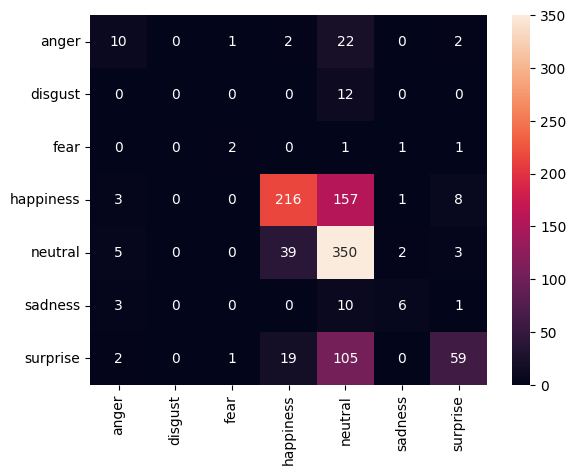

In [21]:
# Confsion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

### Roberta

In [7]:
import wandb

wandb.init(project="Transformers", name="roberta-base")

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 231452 (reinforcement_learning_npac_team_8) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
import evaluate

dataframe_4_bert = df[['text', 'emotion_encoded']]

# Split into train, validation, and test
train_df = dataframe_4_bert[:-NUM_TEST_SAMPLES].reset_index(drop=True)
test_df = dataframe_4_bert[-NUM_TEST_SAMPLES:].reset_index(drop=True)

# Sample validation set (20% of training)
val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Print dataset shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Ensure label column is correctly named for Hugging Face Trainer
dataset = dataset.rename_column("emotion_encoded", "labels")
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize dataset with progress bar (using tqdm)
tokenized_datasets = dataset.map(tokenize_function, batched=True, desc="Tokenizing")

# Convert dataset format
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split dataset
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]

Train shape: (43410, 2)
Validation shape: (10853, 2)
Test shape: (1044, 2)


Tokenizing:   0%|          | 0/43410 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/10853 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1044 [00:00<?, ? examples/s]

In [9]:
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()  # Keep everything on CPU
    result = f1_score.compute(predictions=predictions, references=labels, average='weighted')
    
    return result

# Load model configuration and adjust dropout
config = RobertaConfig.from_pretrained("roberta-base")
config.hidden_dropout_prob = 0.3  # Set dropout rate to 0.3
config.num_labels = num_classes  # Set number of labels for classification

# Now load the model using this modified configuration
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    config=config, 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    disable_tqdm=False,  # Enable progress bar
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=300,
    save_strategy="steps",
    save_steps=300,  # Adjusted to be a multiple of eval_steps
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,  # Restore the best model based on eval loss
    metric_for_best_model="eval_loss",  # Use validation loss for early stopping
    max_steps=10000,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,  # Mixed precision training
    optim="adamw_torch_fused",  # Fused AdamW optimizer for speed
    dataloader_pin_memory=True,  # Speed up GPU memory transfers
    dataloader_num_workers=4,  # Use multiple CPU threads for data loading
    report_to="wandb",  # Log to TensorBoard
    run_name="roberta_f1_classification",  # Optional: You can specify the run name for clarity
    learning_rate=3e-5,
)

# Early stopping callback (patience is set to 2 epochs)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=6)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add the EarlyStoppingCallback here
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,F1
300,1.171000,1.074378,0.591195
600,1.037400,1.006202,0.614195
900,1.016300,0.980078,0.624566
1200,0.967600,0.996037,0.621449
1500,0.931700,0.945111,0.654931
1800,0.942200,0.939236,0.653930
2100,0.935100,0.949404,0.656107
2400,0.888200,1.011388,0.632677
2700,0.906200,0.872320,0.666076
3000,0.863500,0.989310,0.642872


TrainOutput(global_step=4500, training_loss=0.9411493326822916, metrics={'train_runtime': 1008.5837, 'train_samples_per_second': 317.277, 'train_steps_per_second': 9.915, 'total_flos': 3.78786417163776e+16, 'train_loss': 0.9411493326822916, 'epoch': 3.316138540899042})

In [11]:
# Evaluate model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.8723201751708984, 'eval_f1': 0.6660760676060048, 'eval_runtime': 17.5227, 'eval_samples_per_second': 619.367, 'eval_steps_per_second': 19.403, 'epoch': 3.316138540899042}


In [12]:
# Save model
model.save_pretrained("./roberta_finetuned")
tokenizer.save_pretrained("./roberta_finetuned")

('./roberta_finetuned/tokenizer_config.json',
 './roberta_finetuned/special_tokens_map.json',
 './roberta_finetuned/vocab.json',
 './roberta_finetuned/merges.txt',
 './roberta_finetuned/added_tokens.json')

In [14]:
# Load the model for inference
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
model =RobertaForSequenceClassification.from_pretrained("./roberta_finetuned")
tokenizer = RobertaTokenizer.from_pretrained("./roberta_finetuned")

# Load test dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.rename_column("emotion_encoded", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True)

test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

{'eval_loss': 1.1630167961120605, 'eval_f1': 0.5837434805211964, 'eval_runtime': 2.806, 'eval_samples_per_second': 372.054, 'eval_steps_per_second': 11.76, 'epoch': 3.316138540899042}


/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/nlp_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

              precision    recall  f1-score   support

       anger       0.47      0.41      0.43        37
     disgust       0.00      0.00      0.00        12
        fear       0.50      0.40      0.44         5
   happiness       0.69      0.62      0.65       385
     neutral       0.53      0.76      0.62       399
     sadness       0.46      0.30      0.36        20
    surprise       0.78      0.32      0.46       186

    accuracy                           0.60      1044
   macro avg       0.49      0.40      0.42      1044
weighted avg       0.62      0.60      0.58      1044



<Axes: >

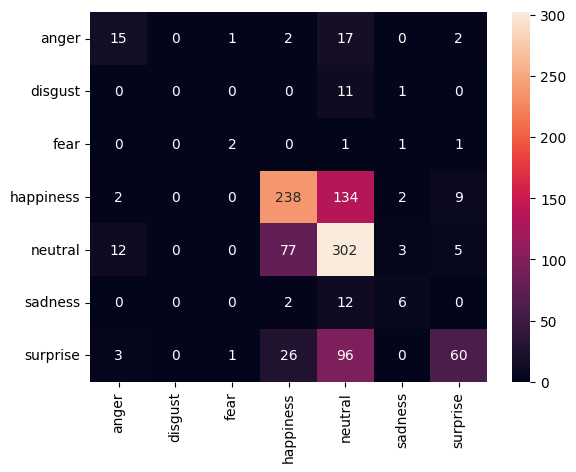

In [15]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
print(classification_report(true_labels, preds, target_names=classes_))

# Confsion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

### DistilRoBerta

In [11]:
import wandb

wandb.init(project="Transformers", name="group_distilbert/distilroberta-base")

In [12]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
import evaluate

dataframe_4_bert = df[['text', 'emotion_encoded']]

# Split into train, validation, and test
train_df = dataframe_4_bert[:-NUM_TEST_SAMPLES].reset_index(drop=True)
test_df = dataframe_4_bert[-NUM_TEST_SAMPLES:].reset_index(drop=True)

# Sample validation set (20% of training)
val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Print dataset shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Convert DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine into DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Ensure label column is correctly named for Hugging Face Trainer
dataset = dataset.rename_column("emotion_encoded", "labels")
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained("distilbert/distilroberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize dataset with progress bar (using tqdm)
tokenized_datasets = dataset.map(tokenize_function, batched=True, desc="Tokenizing")

# Convert dataset format
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split dataset
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]

Train shape: (69278, 2)
Validation shape: (17320, 2)
Test shape: (1044, 2)


Tokenizing:   0%|          | 0/69278 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/17320 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1044 [00:00<?, ? examples/s]

In [15]:
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()  # Keep everything on CPU
    result = f1_score.compute(predictions=predictions, references=labels, average='macro')
    
    return result


# Load model configuration and adjust dropout
config = RobertaConfig.from_pretrained("distilbert/distilroberta-base")
config.hidden_dropout_prob = 0.2  # Set dropout rate to 0.3
config.num_labels = num_classes  # Set number of labels for classification

# Now load the model using this modified configuration
model = RobertaForSequenceClassification.from_pretrained(
    "distilbert/distilroberta-base", 
    config=config, 
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    disable_tqdm=False,  # Enable progress bar
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=300,
    save_strategy="steps",
    save_steps=300,  # Adjusted to be a multiple of eval_steps
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,  # Restore the best model based on eval loss
    metric_for_best_model="eval_loss",  # Use validation loss for early stopping
    max_steps=30000,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,  # Mixed precision training
    optim="adamw_torch_fused",  # Fused AdamW optimizer for speed
    dataloader_pin_memory=True,  # Speed up GPU memory transfers
    dataloader_num_workers=4,  # Use multiple CPU threads for data loading
    report_to="wandb",  # Log to TensorBoard
    run_name="roberta_f1_classification",  # Optional: You can specify the run name for clarity
    learning_rate=3e-5,
)

# Early stopping callback (patience is set to 2 epochs)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=6)

# Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add the EarlyStoppingCallback here
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'train_dataset' is not defined

In [14]:
# Train model
trainer.train()

Step,Training Loss,Validation Loss,F1
300,1.167000,1.088122,0.387275
600,1.073900,1.014953,0.423167
900,1.020300,1.013469,0.459776
1200,0.966600,0.991611,0.522974
1500,0.995500,0.968943,0.546223
1800,0.971200,0.986520,0.539665
2100,0.942300,0.950103,0.552625
2400,0.928200,0.975953,0.543644
2700,0.933800,0.958524,0.556296
3000,0.925200,0.954683,0.560982


TrainOutput(global_step=6900, training_loss=0.9293186707427536, metrics={'train_runtime': 1735.693, 'train_samples_per_second': 1106.186, 'train_steps_per_second': 17.284, 'total_flos': 5.847579359609242e+16, 'train_loss': 0.9293186707427536, 'epoch': 6.3711911357340725})

In [15]:
# Evaluate model
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.9147167205810547, 'eval_f1': 0.5760940905379826, 'eval_runtime': 20.2848, 'eval_samples_per_second': 853.84, 'eval_steps_per_second': 13.36, 'epoch': 6.3711911357340725}


In [ ]:
# Save model
model.save_pretrained("./distilroberta_finetuned_v2")
tokenizer.save_pretrained("./distilroberta_finetuned_v2")

('./distilroberta_finetuned_v2/tokenizer_config.json',
 './distilroberta_finetuned_v2/special_tokens_map.json',
 './distilroberta_finetuned_v2/vocab.json',
 './distilroberta_finetuned_v2/merges.txt',
 './distilroberta_finetuned_v2/added_tokens.json')

In [ ]:
# Load the model for inference
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
model = RobertaForSequenceClassification.from_pretrained("./distilroberta_finetuned_v2")
tokenizer = RobertaTokenizer.from_pretrained("./distilroberta_finetuned_v2")

# Load test dataset
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.rename_column("emotion_encoded", "labels")
test_dataset = test_dataset.map(tokenize_function, batched=True)

test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print(test_results)

Map:   0%|          | 0/1044 [00:00<?, ? examples/s]

{'eval_loss': 0.7635212540626526, 'eval_f1': 0.5623729219976449, 'eval_runtime': 2.0334, 'eval_samples_per_second': 513.419, 'eval_steps_per_second': 8.36, 'epoch': 6.3711911357340725}


              precision    recall  f1-score   support

       anger       0.51      0.51      0.51        37
     disgust       1.00      0.17      0.29        12
        fear       0.50      0.40      0.44         5
   happiness       0.80      0.72      0.76       385
     neutral       0.66      0.79      0.72       399
     sadness       0.55      0.55      0.55        20
    surprise       0.73      0.62      0.67       186

    accuracy                           0.71      1044
   macro avg       0.68      0.54      0.56      1044
weighted avg       0.72      0.71      0.71      1044



<Axes: >

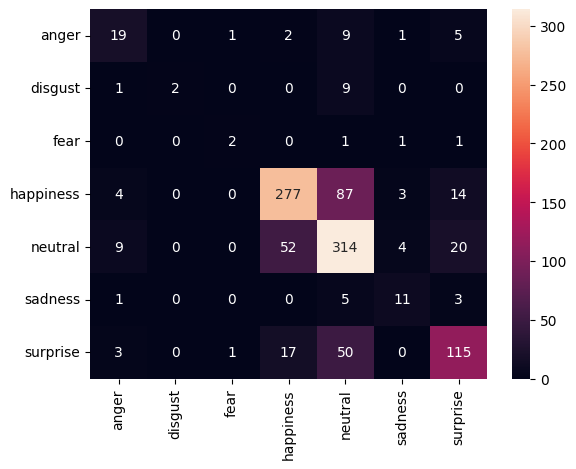

In [18]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
print(classification_report(true_labels, preds, target_names=classes_))

# Confsion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes_, yticklabels=classes_)

### KFOLD

In [6]:
import wandb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
import evaluate
import torch
from sklearn.metrics import f1_score

# Initialize WandB
wandb.init(project="Transformers", name="group_distilbert/distilroberta-base")

# Assuming df is your DataFrame and NUM_TEST_SAMPLES is defined
dataframe_4_bert = df[['text', 'emotion_encoded']]
num_classes = len(dataframe_4_bert['emotion_encoded'].unique())

# Split into train+validation and test sets
train_val_df = dataframe_4_bert[:-NUM_TEST_SAMPLES].reset_index(drop=True)
test_df = dataframe_4_bert[-NUM_TEST_SAMPLES:].reset_index(drop=True)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds_metrics = []

# Tokenizer and Config (consistent across folds)
tokenizer = RobertaTokenizer.from_pretrained("distilbert/distilroberta-base")
config = RobertaConfig.from_pretrained("distilbert/distilroberta-base")
config.hidden_dropout_prob = 0.2
config.num_labels = num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'macro_f1': f1_score(labels, predictions, average='macro'),
        'weighted_f1': f1_score(labels, predictions, average='weighted')
    }

# Perform K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df['text'], train_val_df['emotion_encoded'])):
    print(f"\n=== Fold {fold+1} ===\n")
    
    # Create fold datasets
    fold_train = Dataset.from_pandas(train_val_df.iloc[train_idx])
    fold_val = Dataset.from_pandas(train_val_df.iloc[val_idx])
    
    fold_dataset = DatasetDict({'train': fold_train, 'validation': fold_val})
    fold_dataset = fold_dataset.rename_column("emotion_encoded", "labels")
    
    # Tokenize
    tokenized_fold = fold_dataset.map(tokenize_function, batched=True)
    tokenized_fold.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    
    # Initialize fresh model for each fold
    model = RobertaForSequenceClassification.from_pretrained(
        "distilbert/distilroberta-base",
        config=config
    ).to(device)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold}",
        eval_strategy="steps",
        eval_steps=300,
        save_strategy="steps",
        save_steps=300,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        max_steps=30000,
        weight_decay=0.1,
        logging_dir=f"./logs_fold_{fold}",
        logging_steps=100,
        fp16=True,
        optim="adamw_torch_fused",
        dataloader_pin_memory=True,
        dataloader_num_workers=4,
        report_to="wandb",
        run_name=f"roberta_fold_{fold}",
        learning_rate=3e-5,
        disable_tqdm=False
    )
    
    # Trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_fold["train"],
        eval_dataset=tokenized_fold["validation"],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=6)]
    )
    
    # Train and evaluate
    trainer.train()
    eval_results = trainer.evaluate()
    
    # Store metrics
    folds_metrics.append({
        'macro_f1': eval_results['eval_macro_f1'],
        'weighted_f1': eval_results['eval_weighted_f1']
    })

# Calculate cross-validation results
macro_scores = [m['macro_f1'] for m in folds_metrics]
weighted_scores = [m['weighted_f1'] for m in folds_metrics]

print(f"\nCross-Validation Results:")
print(f"Macro F1: {np.mean(macro_scores):.4f} ± {np.std(macro_scores):.4f}")
print(f"Weighted F1: {np.mean(weighted_scores):.4f} ± {np.std(weighted_scores):.4f}")

# Optional: Train final model on entire training data and evaluate on test set
# (Add similar processing for test_df here if needed)

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 231452 (reinforcement_learning_npac_team_8) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



=== Fold 1 ===



Map:   0%|          | 0/68978 [00:00<?, ? examples/s]

Map:   0%|          | 0/17245 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1,Weighted F1
300,1.061200,1.037215,0.419601,0.609869
600,0.995300,0.991831,0.554359,0.637022
900,0.996900,0.970481,0.559472,0.638632
1200,0.938200,0.969281,0.557795,0.636222
1500,0.916800,0.945029,0.568088,0.644045
1800,0.901600,0.933607,0.582795,0.652624
2100,0.907700,0.946356,0.576205,0.645225
2400,0.847300,0.980155,0.574083,0.640512
2700,0.860500,0.949463,0.588251,0.657266
3000,0.855000,0.956970,0.576374,0.645880



=== Fold 2 ===



Map:   0%|          | 0/68978 [00:00<?, ? examples/s]

Map:   0%|          | 0/17245 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1,Weighted F1
300,1.115100,1.079225,0.438629,0.591515
600,1.002300,1.019097,0.534074,0.626994
900,0.963200,0.980509,0.546405,0.640438
1200,0.940000,0.949549,0.552896,0.649302
1500,0.940900,0.938941,0.552558,0.656433
1800,0.915600,0.946825,0.558744,0.647644
2100,0.926900,0.920232,0.561379,0.658555
2400,0.860000,0.943098,0.563796,0.656557
2700,0.859300,0.943532,0.565495,0.660722
3000,0.874900,0.927889,0.569101,0.658794



=== Fold 3 ===



Map:   0%|          | 0/68978 [00:00<?, ? examples/s]

Map:   0%|          | 0/17245 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1,Weighted F1
300,1.091900,1.025646,0.432643,0.612548
600,1.007200,0.962118,0.542408,0.642679
900,1.000900,0.955622,0.554639,0.642194
1200,0.924400,0.945272,0.564624,0.648243
1500,0.932100,0.918214,0.581549,0.660436
1800,0.884500,0.941629,0.569223,0.649829
2100,0.927900,0.969224,0.565594,0.643038
2400,0.840700,0.943934,0.572783,0.646198
2700,0.869200,0.915854,0.574605,0.658166
3000,0.864600,0.942953,0.572102,0.650809



=== Fold 4 ===



Map:   0%|          | 0/68979 [00:00<?, ? examples/s]

Map:   0%|          | 0/17244 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1,Weighted F1
300,1.060900,1.033993,0.430077,0.617148
600,1.017400,0.975315,0.543494,0.644543
900,0.999100,0.972223,0.544592,0.640106
1200,0.927700,0.933938,0.568574,0.654928
1500,0.912900,0.990802,0.549716,0.628606
1800,0.902500,0.936587,0.568928,0.649976
2100,0.904900,0.941818,0.573547,0.654243
2400,0.861200,0.967907,0.568809,0.638981
2700,0.846300,0.924618,0.576343,0.661399
3000,0.861600,0.934698,0.578214,0.660982



=== Fold 5 ===



Map:   0%|          | 0/68979 [00:00<?, ? examples/s]

Map:   0%|          | 0/17244 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1,Weighted F1
300,1.059500,1.092568,0.413931,0.582114
600,1.004400,0.977009,0.520666,0.639593
900,0.998500,0.981952,0.546564,0.639207
1200,0.922200,0.952880,0.565897,0.652756
1500,0.922000,0.943026,0.557955,0.647780
1800,0.909300,0.936874,0.567490,0.656193
2100,0.899100,0.934660,0.568299,0.659392
2400,0.864900,0.984026,0.560924,0.637793
2700,0.826400,0.928454,0.583665,0.666777
3000,0.873900,0.926330,0.579907,0.662074



Cross-Validation Results:
Macro F1: 0.5760 ± 0.0086
Weighted F1: 0.6595 ± 0.0019


## STEP 12: COLLECT AND PRINT FINAL RESULTS

In [ ]:
print("\n=== FINAL SUMMARY ===")
print(f"Logistic Regression F1: {f1_lr:.4f}")
print(f"Naive Bayes F1: {f1_nb:.4f}")
print(f"LSTM F1: {f1_lstm:.4f}")
print(f"RNN F1: {f1_rnn:.4f}")
print(f"BERT F1: {eval_results_bert['eval_f1_macro']:.4f}")
print(f"DistilBERT F1: {eval_results_distil['eval_f1_macro']:.4f}")

"""
NOTE: 
1. For each model/iteration, record details (features used, hyperparameters, F1-score, comments) 
   in your model iteration file.
2. Feel free to adjust hyperparameters (batch size, number of epochs, etc.) to improve results.
3. You may also incorporate more features (POS tags, Pretrained_Embeddings, etc.) 
   by modifying the make_feature_vector() function or building advanced architectures.
4. This example focuses on demonstrating the core steps; you must tailor it to your specific project setup.
"""